In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
import keras.utils as ku 
import pandas as pd
import numpy as np
import string, os 
import warnings

import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
nltk.download('stopwords')

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub(' ', text)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [0]:
data = pd.read_csv("/content/drive/My Drive/NLP_Data/articles.csv", encoding="latin-1")
data['text'] = data['text'].apply(clean_text)
articles = list(data['text'].values)
corpus = [x for x in articles[:200]]
len(articles)
seq_length = 20

In [6]:
t = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0)
t.fit_on_texts(corpus)
print('Found %s unique tokens.' % len(t.word_index))

Found 13664 unique tokens.


In [7]:
def get_sequence_of_tokens(corpus):
    total_words = len(t.word_index) + 1
    
    input_sequences = []
    for line in corpus:
        token_list = t.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)-seq_length):
            n_gram_sequence = token_list[i:i+seq_length]
            input_sequences.append(n_gram_sequence)
            
    return input_sequences, total_words
input_sequences, total_words = get_sequence_of_tokens(corpus)
print(len(input_sequences))

206467


In [10]:
t.sequences_to_texts(input_sequences[:15])

['headlines blared chatbots next big thing hopes sky high bright eyed bushy tailed industry ripe new era innovation time start',
 'blared chatbots next big thing hopes sky high bright eyed bushy tailed industry ripe new era innovation time start socializing',
 'chatbots next big thing hopes sky high bright eyed bushy tailed industry ripe new era innovation time start socializing machines',
 'next big thing hopes sky high bright eyed bushy tailed industry ripe new era innovation time start socializing machines road',
 'big thing hopes sky high bright eyed bushy tailed industry ripe new era innovation time start socializing machines road signs',
 'thing hopes sky high bright eyed bushy tailed industry ripe new era innovation time start socializing machines road signs pointed',
 'hopes sky high bright eyed bushy tailed industry ripe new era innovation time start socializing machines road signs pointed towards',
 'sky high bright eyed bushy tailed industry ripe new era innovation time star

In [0]:
def generate_padded_sequences(input_sequences):
    input_sequences = np.array(pad_sequences(input_sequences,
                                          maxlen = seq_length, padding = 'pre'))
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes = total_words)
    
    return predictors, label

predictors, label= generate_padded_sequences(input_sequences)

In [0]:
def create_model(sequence_len, total_words):
    model = Sequential()
    model.add(Embedding(total_words, sequence_len, input_length=sequence_len - 1))
    model.add(LSTM(100,return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(total_words,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

model = create_model(seq_length, total_words)
model.summary()
cp=ModelCheckpoint('/content/drive/My Drive/NLP_Data/model_lstm_20.hdf5',
                   monitor='loss',verbose=1,save_best_only=True, period = 5)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 19, 20)            273300    
_________________________________________________________________
lstm_2 (LSTM)                (None, 19, 100)           48400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 13665)             1380165   
Total params: 1,792,365
Trainable params: 1,792,365
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)          

In [0]:
history = model.fit(predictors, label, epochs=100, verbose=1, callbacks=[cp])

Epoch 1/100
6453/6453 [==============================] - 62s 10ms/step - loss: 8.0978 - accuracy: 0.0165
Epoch 2/100
6453/6453 [==============================] - 62s 10ms/step - loss: 7.7762 - accuracy: 0.0269
Epoch 3/100
6453/6453 [==============================] - 61s 10ms/step - loss: 7.5477 - accuracy: 0.0320
Epoch 4/100
6453/6453 [==============================] - 61s 10ms/step - loss: 7.3331 - accuracy: 0.0365
Epoch 5/100
6448/6453 [============================>.] - ETA: 0s - loss: 7.1282 - accuracy: 0.0416
Epoch 00005: loss improved from inf to 7.12815, saving model to /content/drive/My Drive/NLP_Data/model_lstm_20.hdf5
6453/6453 [==============================] - 61s 9ms/step - loss: 7.1282 - accuracy: 0.0416
Epoch 6/100
6453/6453 [==============================] - 62s 10ms/step - loss: 6.9311 - accuracy: 0.0467
Epoch 7/100
6453/6453 [==============================] - 63s 10ms/step - loss: 6.7385 - accuracy: 0.0524
Epoch 8/100
6453/6453 [==============================] - 62s 10

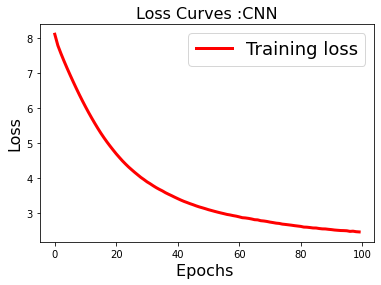

In [0]:
import matplotlib.pyplot as plt

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.legend(['Training loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
plt.show() 

In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/NLP_Data/model_lstm_final.hdf5')

In [0]:
def generate_text(seed_text, next_words, model, max_seq_len):
    for _ in range(next_words):
        token_list = t.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predicted = model.predict_classes(token_list, verbose=0)
        output_word = ''
        for word,index in t.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text = seed_text + " " + output_word
    return seed_text.title()

In [0]:
print(generate_text("machine learning", 1, model, seq_length))

Machine Learning Techniques


In [0]:
import pickle
with open('/content/drive/My Drive/NLP_Data/tokenier.pickle', 'wb') as handle:
    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)